## PseudoGT-Generator Test

In [1]:
%load_ext autoreload
%autoreload 2

import guidance.pgt as lg

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import torch


Function to load created inference gifs and create a batch with the frames of the gifs:

In [9]:
def get_frame(frame_nr, path):
    gif = Image.open(os.path.join(os.getcwd(), path))
    gif.seek(frame_nr)
    frame = np.array(gif)

    frame = frame[:,:,0]

    classes = []
    num_classes = 4
    padding = 10

    x_coord = padding
    y_coord = padding
    image_size = 154
    for i in range(num_classes):
        classes.append(torch.from_numpy(frame[y_coord:y_coord+image_size, x_coord:x_coord+image_size] / 255))
        x_coord = x_coord + image_size + padding

    return torch.stack(classes, dim=0)


In [10]:
def create_batch(path, frames: list[int]):
    batch = []
    for frame in frames:
        batch.append(get_frame(frame, path))
    return torch.stack(batch, dim=0)


In [100]:
from matplotlib.gridspec import GridSpec

def plot_pseudo_gt(pseudo_gt, prediction):
    num_classes = pseudo_gt.shape[0]

    fig = plt.figure(layout="constrained", figsize=(10, num_classes * 6))
    gs = GridSpec(num_classes, 2, left=0.1, bottom=0.25, right=0.95, top=0.95,
        wspace=0.0, hspace=0.5, width_ratios=[1, 1])
    
    for i in range(num_classes):
        ax = fig.add_subplot(gs[i,0])
        ax.imshow(pseudo_gt[i], cmap='gray')
        # ax.set_axis_off()

        ax = fig.add_subplot(gs[i,1])
        ax.imshow(prediction[i], cmap='gray')
        # ax.set_axis_off()

    plt.show()


In [103]:
def likelyhood_temperature_scaling(x_softmax: torch.Tensor, likelyhood: torch.Tensor, alpha: float=1.0, beta: float=1.0):
    """
        Likelihood temperature scaling of the softmax output. 
        params:
            x_softmax: torch.Tensor, shape (batch_size, num_classes, height, width)
            likelyhood: torch.Tensor, shape (batch_size, num_classes, height, width)
            alpha: float, between 0 and 1, default 1.0
        returns:
            torch.Tensor, shape (batch_size, num_classes, height, width)
    """

    x_softmax = x_softmax / ((1-likelyhood)**beta) * alpha + torch.softmax(x_softmax, dim=1) * (1-alpha)
    return x_softmax / torch.sum(x_softmax, dim=1)

Config for the Pseudo-Generator:

In [91]:
from omegaconf import OmegaConf

config = {
    "num_classes": 4,
    "topo_features": {
        0: {0: 1, 1: 1},
        1: {0: 1, 1: 0},
        2: {0: 1, 1: 1},
        3: {0: 1, 1: 0}
    },
    "scaling_function": {
        "alpha": 1.0
    },
    "analysis": {
        "num_bins": 50,
        "poly_degree": 5,
        "minimal_threshold": 0.25
    }
}

config = OmegaConf.create(config)

In [111]:
batch = create_batch('../results/gif_over_timesteps_7.gif', [8])

pseudo_gt_generator = lg.PseudoGTGeneratorDim0_Comps(config)
pseudo_gt = pseudo_gt_generator.pseudo_gt(batch, no_scaling=True)
print(pseudo_gt.shape)



num edges: 47124
num cubes: 94249
num components: 1
num bins: 50
thresholds: [0.78260007 0.24638106]
birth value: 0.9764705896377563, death value: -inf, thresholds: [0.78260007 0.24638106], minimal threshold: 0.25
remaining thresholds after birth value: [0.78260007 0.24638106]
remaining thresholds after minimal threshold: [0.78260007]
using interval: (0, inf), threshold: 0.7826000708202528 for copmonent map
num edges: 47124
num cubes: 94249
num components: 1
num bins: 50
thresholds: [0.78275071 0.41133872]
birth value: 0.9490196108818054, death value: -inf, thresholds: [0.78275071 0.41133872], minimal threshold: 0.25
remaining thresholds after birth value: [0.78275071 0.41133872]
remaining thresholds after minimal threshold: [0.78275071 0.41133872]
using interval: (0, inf), threshold: 0.4113387225986748 for copmonent map
num edges: 47124
num cubes: 94249
num components: 1
num bins: 50
thresholds: [0.71340488 0.39064687]
birth value: 0.9333333373069763, death value: -inf, thresholds: [0

c:\Users\stefk\.conda\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


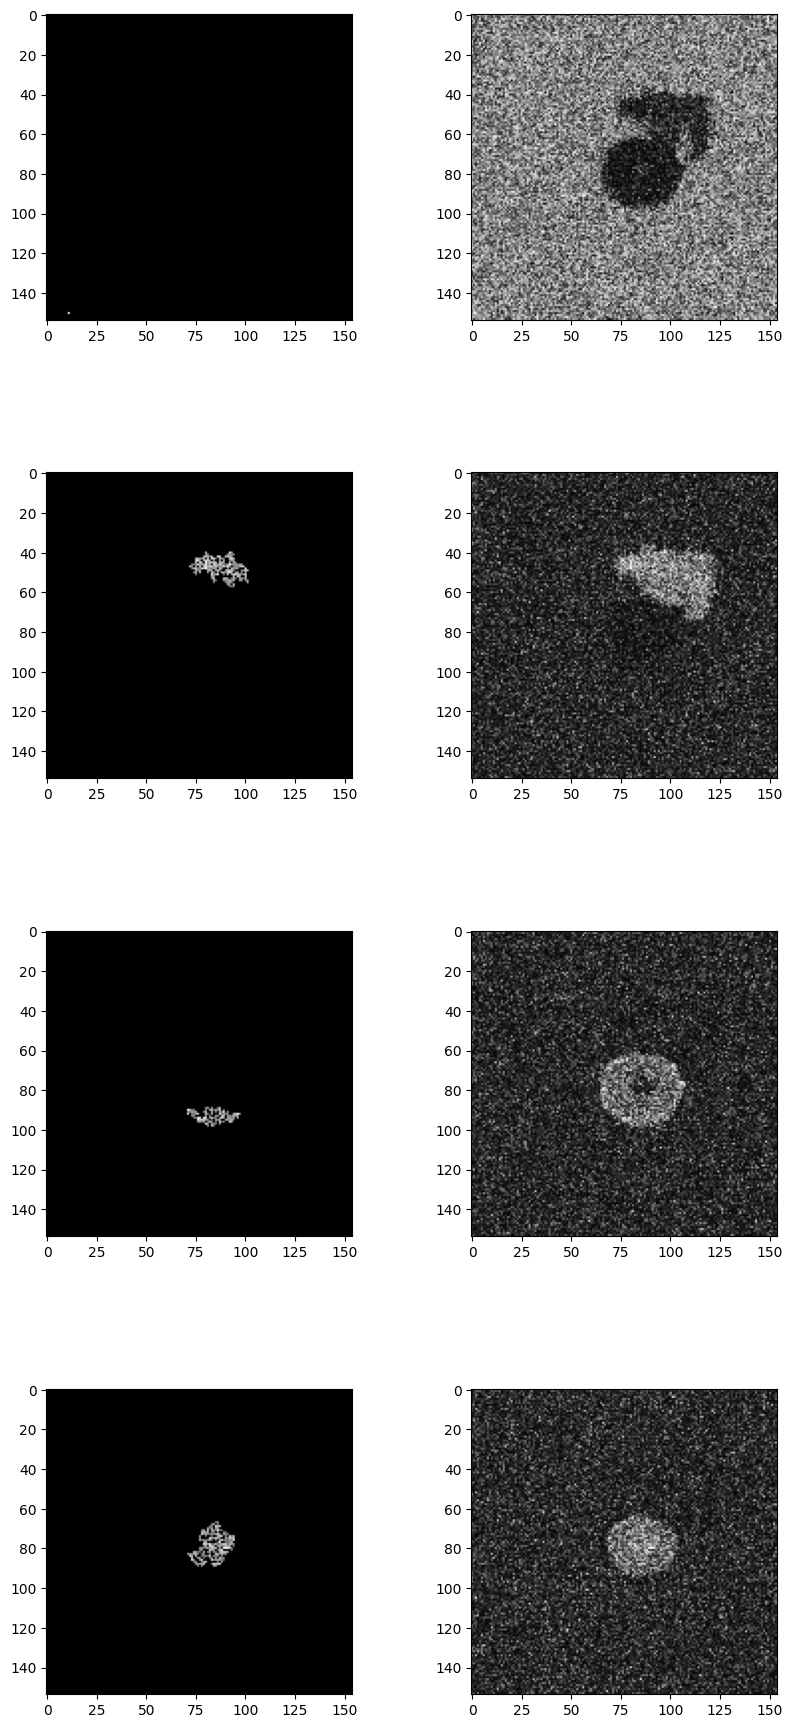

In [116]:
batch_idx = 0
assert pseudo_gt.shape[0] > batch_idx

alpha = 1.0
beta = 10.0
pseudo_gt_scaled = likelyhood_temperature_scaling(batch, pseudo_gt, alpha, beta)

plot_pseudo_gt(pseudo_gt[batch_idx], batch[batch_idx])

In [81]:
print(f"pseudo gt: {pseudo_gt[0,2, 10:20, :10 ]}")
print(f"batch: {batch[0,2,:5, 10:20]}")

print(f"pseudo gt: {pseudo_gt[0,2, 13, 1]}")


pseudo gt: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.4471, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]]